# LGBM on time series data of cryptocurrency prices
The dataset used in this notebook can be found here: https://www.kaggle.com/competitions/g-research-crypto-forecasting/data

I will compare two LGBM baselines,

* one that considers each asset independently (i.e. For each asset a Model File will be saved) and,
* one multiple inputs that models all assets together (i.e. single Model File will be saved).

And in the competition, the predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the Weight column in the Asset Details file.

In [1]:
import os
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import joblib
import time
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')
from xgboost import XGBRegressor
import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

/tmp/ipykernel_20/2106194749.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


In [2]:
ROOT_DIR = '/kaggle/input/g-research-crypto-forecasting'

## Config

In [3]:
class CFG:
    INPUT_DIR = ROOT_DIR
    OUTPUT_DIR = './'
    SEED = 42

## Reduce the memory footprint of the dataset
Based on the data type and the range of values, the function below determines the smallest possible data type that can accommodate the data without losing information. For example, if the data type is an integer and the range of values fits within the bounds of an int8 data type, the function converts the column data type to int8.

In [4]:
def get_optimal_numeric_type(c_min: float, c_max: float, col_type: str) -> str:
    """
    Determines the optimal numeric data type for a given range of values.

    Parameters
    ----------
    c_min : float
        The minimum value of the data.
    c_max : float
        The maximum value of the data.
    col_type : str
        The current data type of the column ('int' or 'float').

    Returns
    -------
    optimal_type : str
        The optimal data type for the given range of values.
    """
    type_info = np.iinfo if col_type == 'int' else np.finfo
    for dtype in [np.int8, np.int16, np.int32, np.int64, np.float16, np.float32, np.float64]:
        if col_type in str(dtype):
            if c_min > type_info(dtype).min and c_max < type_info(dtype).max:
                return dtype
    return None

""" Based on the data type and the range of values, the function determines the smallest possible data type that can accommodate the data without losing information. For example, if the data type is an integer and the range of values fits within the bounds of an int8 data type, the function converts the column data type to int8: """

def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reduces memory usage of a pandas DataFrame by converting its columns to the most memory-efficient data types
    without losing information.

    Parameters
    ----------
    df : pd.DataFrame
        The input pandas DataFrame that needs memory optimization.

    Returns
    -------
    df : pd.DataFrame
        The optimized pandas DataFrame with reduced memory usage.
    """

    # Iterate through each column in the DataFrame
    df_copy = df.copy()
    for col in df_copy.columns:
        col_type = df_copy[col].dtype

        # Check if the data type is not an object (i.e., numeric type)
        if col_type != object:
            c_min, c_max = df_copy[col].min(), df_copy[col].max()
            col_type_str = 'int' if 'int' in str(col_type) else 'float'
            optimal_type = get_optimal_numeric_type(c_min, c_max, col_type_str)
            if optimal_type:
                df_copy[col] = df_copy[col].astype(optimal_type)
        # If the data type is an object, convert the column to a 'category' data type
        else:
            df_copy[col] = df_copy[col].astype('category')

    # Return the optimized DataFrame with reduced memory usage
    return df_copy

## The dataset - train.csv
* timestamp - A timestamp for the minute covered by the row.
* Asset_ID - An ID code for the cryptoasset.
* Count - The number of trades that took place this minute.
* Open - The USD price at the beginning of the minute.
* High - The highest USD price during the minute.
* Low - The lowest USD price during the minute.
* Close - The USD price at the end of the minute.
* Volume - The number of cryptoasset units traded during the minute.
* VWAP - The volume weighted average price for the minute.
* Target - 15 minute residualized returns. 

In [5]:
before = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'train.csv'))
before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [6]:
%%time

train = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'train.csv')).pipe(reduce_memory_usage)
print(train.shape)
train.head()

(24236806, 10)
CPU times: user 49.7 s, sys: 10.8 s, total: 1min
Wall time: 1min 6s


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219
1,1514764860,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397
2,1514764860,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641
3,1514764860,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924
4,1514764860,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263


In [7]:
train.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
24236801,1632182400,9,775.0,157.125000,157.250000,156.750000,157.000000,4.663726e+03,156.994319,NaN
24236802,1632182400,10,34.0,2438.000000,2438.000000,2430.000000,2432.000000,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091370,0.091553,0.091248,0.091370,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282227,0.282471,0.281738,0.281982,1.828508e+05,0.282134,NaN
24236805,1632182400,11,48.0,232.750000,232.750000,232.250000,232.250000,1.035123e+02,232.569697,NaN


In [8]:
train.info() # A quite nice memory reduction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int32  
 1   Asset_ID   int8   
 2   Count      float32
 3   Open       float16
 4   High       float16
 5   Low        float16
 6   Close      float16
 7   Volume     float32
 8   VWAP       float64
 9   Target     float16
dtypes: float16(5), float32(2), float64(1), int32(1), int8(1)
memory usage: 716.5 MB


In [9]:
# missing values?
train.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

## asset_details.csv
Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.

In [10]:
asset_details = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'asset_details.csv'))
asset_details['Asset_ID'] = asset_details['Asset_ID'].astype(np.int8)
print(asset_details.shape)
asset_details

(14, 3)


,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Feature engineering

In [11]:
# select train and validation period

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))

train_window = [totimestamp("01/01/2018"), totimestamp("01/06/2021")]

valid_window = [totimestamp("02/06/2020"), totimestamp("21/09/2021")]

train = train.set_index("timestamp")

beg_ = train.index[0].astype('datetime64[s]')
end_ = train.index[-1].astype('datetime64[s]')
""" taking the first and last index values and converting the retrieved index values into datetime objects with second precision. """

print('>> data goes from ', beg_, 'to ', end_, 'shape=', train.shape)

# drop rows without target
train.dropna(subset=['Target'], inplace=True)

# add train flag
train['train_flg'] = 1

train.loc[valid_window[0]:valid_window[1], 'train_flg'] = 0

>> data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00 shape= (24236806, 9)


### Merge the Asset Details .csv file to get the "Weights" for each of the Assets, which will be required for the evaluation parts

In [12]:
def merge_asset_details(train, asset_details):
    """Add asset details to train df
    """
    return train.merge(
        asset_details
        , how='left'
        , on='Asset_ID'
    )

# merge asset_details
train = merge_asset_details(train, asset_details)

In [13]:
def get_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract additional features from the given DataFrame for financial analysis.
    
    Parameters
    ----------
    df : pd.DataFrame
        A pandas DataFrame containing the stock data with columns:
        'Open', 'High', 'Low', 'Close', 'Volume', and 'Count'.
    
    Returns
    -------
    df_copy : pd.DataFrame
        A new DataFrame with the extracted features as additional columns.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Calculate the upper and lower shadows for the candlestick chart
    df_copy['upper_shadow'] = df_copy['High'] - np.maximum(df_copy['Close'], df_copy['Open'])
    df_copy['lower_shadow'] = np.minimum(df_copy['Close'], df_copy['Open']) - df_copy['Low']

    # Calculate the ratio of closing price to opening price
    df_copy['open2close'] = df_copy['Close'] / df_copy['Open']

    # Calculate the ratio of the highest price to the lowest price
    df_copy['high2low'] = df_copy['High'] / df_copy['Low']

    # Calculate the mean and median prices for each row
    mean_price = df_copy[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_copy[['Open', 'High', 'Low', 'Close']].median(axis=1)

    # Calculate the ratios of high and low prices to the mean and median prices
    df_copy['high2mean'] = df_copy['High'] / mean_price
    df_copy['low2mean'] = df_copy['Low'] / mean_price
    df_copy['high2median'] = df_copy['High'] / median_price
    df_copy['low2median'] = df_copy['Low'] / median_price

    # Calculate the ratio of volume to the count, adding 1 to avoid division by zero
    df_copy['volume2count'] = df_copy['Volume'] / (df_copy['Count'] + 1)

    return df_copy

In [14]:
%%time

feature_df = get_features(train)

print(feature_df.shape)
feature_df.tail()

(23486468, 21)
CPU times: user 26.3 s, sys: 3.27 s, total: 29.5 s
Wall time: 29.6 s


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,...,Asset_Name,upper_shadow,lower_shadow,open2close,high2low,high2mean,low2mean,high2median,low2median,volume2count
23486463,9,163.0,156.500000,156.625000,156.000000,156.125000,7.381963e+02,156.260253,-0.001154,0,...,Litecoin,0.125000,0.125000,0.997559,1.003906,1.001953,0.998535,1.001953,0.998535,4.501197
23486464,10,23.0,2420.000000,2420.000000,2412.000000,2414.000000,1.315794e+00,2417.326038,0.009834,0,...,Maker,0.000000,2.000000,0.997559,1.002930,1.001953,0.998535,1.001953,0.998535,0.054825
23486465,13,512.0,0.091003,0.091125,0.090820,0.090881,1.900696e+06,0.090943,0.004162,0,...,TRON,0.000122,0.000061,0.998535,1.002930,1.001953,0.998535,1.001953,0.998535,3705.059570
23486466,12,193.0,0.281006,0.281250,0.280273,0.280518,1.628699e+05,0.280655,0.000449,0,...,Stellar,0.000244,0.000244,0.998047,1.003906,1.001953,0.998047,1.001953,0.998047,839.535583
23486467,11,38.0,232.125000,232.250000,231.250000,231.625000,4.914804e+01,231.794078,0.002567,0,...,Monero,0.125000,0.375000,0.998047,1.003906,1.001953,0.997070,1.001953,0.997070,1.260206


In [15]:
feature_df.columns

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target', 'train_flg', 'Weight', 'Asset_Name', 'upper_shadow',
       'lower_shadow', 'open2close', 'high2low', 'high2mean', 'low2mean',
       'high2median', 'low2median', 'volume2count'],
      dtype='object')

## Light GBM

In [16]:
target = 'Target'

# drops = ['timestamp', 'Asset_Name', 'Weight', 'train_flg', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
drops = ['Asset_Name']
features_selected_for_training = [f for f in train.columns if f not in drops + [target]]

categoricals = ['Asset_ID']

print('{:,} features_selected_for_training: {}'.format(len(features_selected_for_training), features_selected_for_training))

10 features_selected_for_training: ['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'train_flg', 'Weight']


### LGBM Configurations

In [17]:
params = {
        'n_estimators': 10000,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'subsample': 0.72,
        'subsample_freq': 4,
        'feature_fraction': 0.4,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'seed': 42,
        }

### Train Full Model (i.e. a single model file will be saved)

In [18]:
def train_lgbm_model(feature_df, features_selected_for_training, target, categoricals, params):
    """
    Train an LGBM model on the given feature DataFrame, save the model and return feature importances.
    
    Parameters
    ----------
    feature_df : pd.DataFrame
        DataFrame containing the features_selected_for_training and target variable
    features_selected_for_training : list of str
        List of feature names used for training the model
    target : str
        Name of the target variable
    categoricals : list of str
        List of categorical feature names
    params : dict
        Dictionary of parameters for the LGBM model
    output_dir : str
        Directory to save the trained model
    
    Returns
    -------
    fi_df : pd.DataFrame
        DataFrame containing the feature importances
    """
    
    # Instantiate the LGBM model
    model = lgb.LGBMRegressor(**params)

    # Fit the model on the training data and validate on the validation data
    model.fit(
        feature_df.query('train_flg == 1')[features_selected_for_training],
        feature_df.query('train_flg == 1')[target].values, 
        eval_set=[(feature_df.query('train_flg == 0')[features_selected_for_training]
                   , feature_df.query('train_flg == 0')[target].values)],
        verbose=-1, 
        early_stopping_rounds=100,
        categorical_feature=categoricals,
    )
    
    return model

In [19]:
model = train_lgbm_model(feature_df, features_selected_for_training, target, categoricals, params)

# save model
joblib.dump(model, os.path.join(CFG.OUTPUT_DIR, 'lgb_model_val.pkl'))

print('LGBM model saved to output dir')

# feature importance
fi_df = pd.DataFrame()
fi_df['features_selected_for_training'] = features_selected_for_training
fi_df['importance'] = model.booster_.feature_importance(importance_type="gain")

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
LGBM model saved to output dir


<Axes: xlabel='importance', ylabel='features_selected_for_training'>

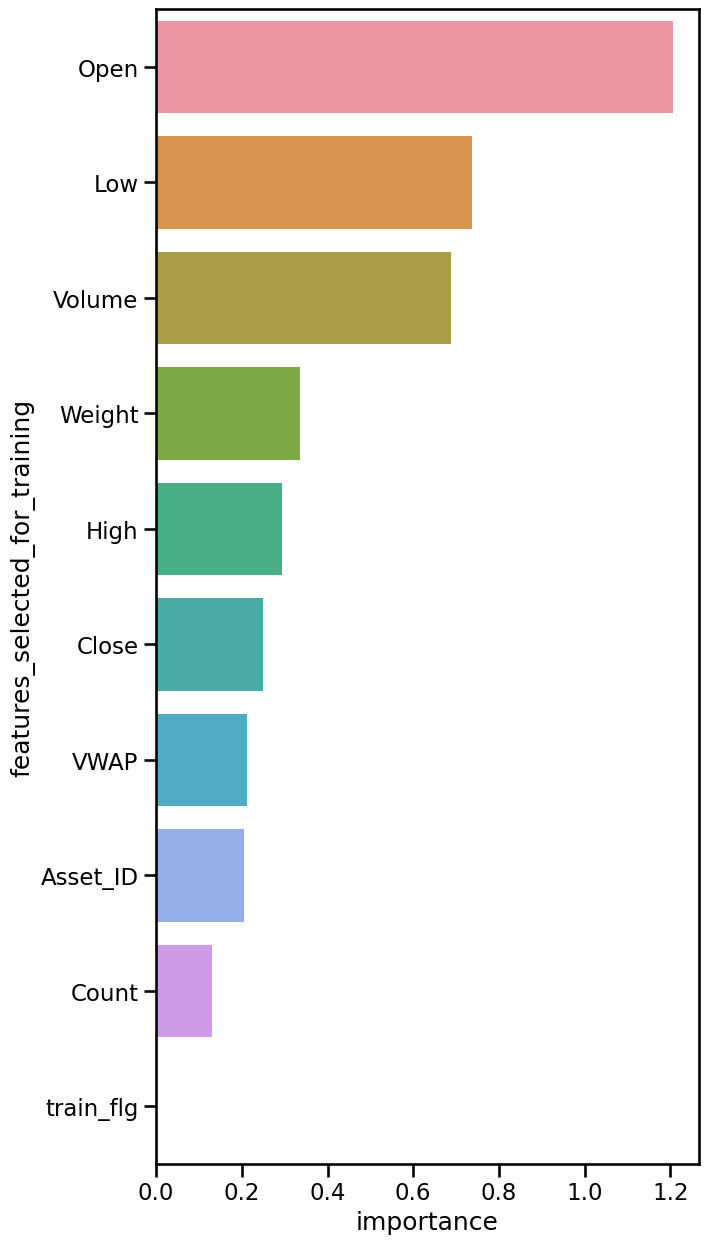

In [20]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(
    x='importance'
    , y='features_selected_for_training'
    , data=fi_df.sort_values(by=['importance'], ascending=False)
    , ax=ax
)

### Train individual model (i.e. for each asset a model file will be saved)

In [21]:
def train_lgbm_model_for_asset(asset, feature_df, features_selected_for_training, target, params, output_dir):
    """
    Train an LGBM model on the given feature DataFrame for a specific asset, and save the model.
    
    Parameters
    ----------
    asset : int
        Asset_ID for which the model is trained
    feature_df : pd.DataFrame
        DataFrame containing the features and target variable
    features_selected_for_training : list of str
        List of selected feature names used for training the model
    target : str
        Name of the target variable
    params : dict
        Dictionary of parameters for the LGBM model
    output_dir : str
        Directory to save the trained model
    """

    # Instantiate the LGBM model
    model = lgb.LGBMRegressor(**params)

    # Train the model on the specific asset and validate
    train_data = feature_df.query('train_flg == 1 and Asset_ID == @asset')
    val_data = feature_df.query('train_flg == 0 and Asset_ID == @asset')
    
    model.fit(
        train_data[features_selected_for_training],
        train_data[target].values, 
        eval_set=[(val_data[features_selected_for_training], val_data[target].values)],
        verbose=-1, 
        early_stopping_rounds=100,
    )
    
    # Save the model
    asset_name = train_data['Asset_Name'].values[0]
    model_path = os.path.join(output_dir, f'lgb_model_{asset_name}_val.pkl')
    joblib.dump(model, model_path)
    print(f'lgb model for {asset_name} saved!')

# Train LGBM models for each asset
for asset in feature_df['Asset_ID'].unique():
    train_lgbm_model_for_asset(asset, feature_df, features_selected_for_training, target, params, CFG.OUTPUT_DIR)

lgb model for Bitcoin Cash saved!
lgb model for Binance Coin saved!
lgb model for Bitcoin saved!
lgb model for EOS.IO saved!
lgb model for Ethereum Classic saved!
lgb model for Ethereum saved!
lgb model for Litecoin saved!
lgb model for Monero saved!
lgb model for TRON saved!
lgb model for Stellar saved!
lgb model for Cardano saved!
lgb model for IOTA saved!
lgb model for Maker saved!
lgb model for Dogecoin saved!


### Evaluation score - weighted correlation

In [22]:
def weighted_mean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(prediction, target, w):
    """Weighted Covariance"""
    return np.sum(w * (prediction - weighted_mean(prediction, w)) * (target - weighted_mean(target, w))) / np.sum(w)

""" (prediction - weighted_mean(prediction, w)) * (target - weighted_mean(target, w))

This calculate the differences between each data point and their respective weighted means. 
These differences are then element-wise multiplied by the weight array w. """

def corr(prediction, target, w):
    """Weighted Correlation"""
    return cov(prediction, target, w) / np.sqrt(cov(prediction, prediction, w) * cov(target, target, w))

### Evaluating the full model

In [23]:
# Compute the correlation
print('Load the FULL MODEL *******************************************')

model = joblib.load(os.path.join(CFG.OUTPUT_DIR, 'lgb_model_val.pkl'))

val_df = train.query('train_flg == 0').copy()

val_df['Prediction'] = model.predict(val_df[features_selected_for_training])

for asset in val_df['Asset_ID'].unique():
    tmp = val_df.query('Asset_ID == @asset')
    coin = tmp['Asset_Name'].values[0]
    
    r = corr(tmp['Prediction'], tmp['Target'], tmp['Weight'])
    
    print('')
    
    print('- {}: Validation Score (weighted correlation) = {:.4f}'.format(coin, r))

r = corr(val_df['Prediction'], val_df['Target'], val_df['Weight'])

print('=> Overall Validation Score (weighted correlation) = {:.4f}'.format(r))

Load the FULL MODEL *******************************************

- Cardano: Validation Score (weighted correlation) = 0.0245

- Bitcoin Cash: Validation Score (weighted correlation) = 0.0127

- Binance Coin: Validation Score (weighted correlation) = 0.0240

- Bitcoin: Validation Score (weighted correlation) = -0.0107

- Dogecoin: Validation Score (weighted correlation) = 0.0147

- EOS.IO: Validation Score (weighted correlation) = 0.0071

- Ethereum Classic: Validation Score (weighted correlation) = 0.0124

- Ethereum: Validation Score (weighted correlation) = 0.0148

- Litecoin: Validation Score (weighted correlation) = -0.0064

- TRON: Validation Score (weighted correlation) = -0.0026

- Stellar: Validation Score (weighted correlation) = 0.0079

- Monero: Validation Score (weighted correlation) = -0.0010

- IOTA: Validation Score (weighted correlation) = 0.0055

- Maker: Validation Score (weighted correlation) = 0.0012
=> Overall Validation Score (weighted correlation) = 0.0118


### Evaluating the individual models

In [24]:
asset_name = feature_df.query('Asset_ID == @asset')['Asset_Name'].values[0]

In [25]:
print('INDIVIDUAL MODEL *******************************************')
val_df['Prediction'] = 0
for asset in val_df['Asset_ID'].unique():
    asset_name = feature_df.query('Asset_ID == @asset')['Asset_Name'].values[0]
    # load model
    model = joblib.load(os.path.join(CFG.OUTPUT_DIR, 'lgb_model_{}_val.pkl'.format(asset_name)))
    
    # inference
    val_df.loc[val_df['Asset_ID'] == asset, 'Prediction'] = model.predict(val_df.loc[val_df['Asset_ID'] == asset, features_selected_for_training])
    # Explanation of => vmodel.predict(val_df.loc[val_df['Asset_ID'] == asset, features_selected_for_training])
    # The loc function is a label-based indexer that allows you to select rows and columns by their labels. 
    # Essentially, this line selects all the rows where the 'Asset_ID' matches the 'asset' variable.
    # And then => ..., features_selected_for_training: => This part specifies the columns to be selected from the filtered DataFrame. 
    # So 'features_selected_for_training" is a list of column names that you want to keep in the output. So overall, The loc function will return only these columns for the selected rows.
    
    tmp = val_df.query('Asset_ID == @asset')
    
    asset_name = tmp['Asset_Name'].values[0]
    
    r = corr(tmp['Prediction'], tmp['Target'], tmp['Weight'])
    
    print('')
    
    print('- {}: Validation Score (weighted correlation) = {:.4f}'.format(asset_name, r))
    
r = corr(val_df['Prediction'], val_df['Target'], val_df['Weight'])
print('=> Overall Validation Score (weighted correlation) = {:.4f}'.format(r))

INDIVIDUAL MODEL *******************************************

- Cardano: Validation Score (weighted correlation) = 0.0065

- Bitcoin Cash: Validation Score (weighted correlation) = 0.0115

- Binance Coin: Validation Score (weighted correlation) = 0.0085

- Bitcoin: Validation Score (weighted correlation) = 0.0049

- Dogecoin: Validation Score (weighted correlation) = 0.0015

- EOS.IO: Validation Score (weighted correlation) = 0.0063

- Ethereum Classic: Validation Score (weighted correlation) = 0.0042

- Ethereum: Validation Score (weighted correlation) = 0.0121

- Litecoin: Validation Score (weighted correlation) = 0.0074

- TRON: Validation Score (weighted correlation) = -0.0028

- Stellar: Validation Score (weighted correlation) = 0.0081

- Monero: Validation Score (weighted correlation) = 0.0143

- IOTA: Validation Score (weighted correlation) = 0.0138

- Maker: Validation Score (weighted correlation) = 0.0086
=> Overall Validation Score (weighted correlation) = 0.0051


The full model seems to be performing better than the individual models.